# cNMF in `cellarium-ml`

Stephen Fleming, Yang Xu

2025.07.31

The `cellarium-ml` project:

https://github.com/cellarium-ai/cellarium-ml

The specific implementation of cNMF we are actively working on:

https://github.com/cellarium-ai/cellarium-ml/pull/196

## Overview

`cellarium-ml` implements a variety of algorithms in a way that is scalable to hundreds of millions of cells and beyond.
This notebook provides a demo run of Cellarium's implementation of consensus NMF (cNMF).
The specific algorithm for NMF is based on "Online learning for matrix factorization and sparse coding" by Mairal, Bach, Ponce, and Sapiro (JMLR 2010).

## This notebook

This notebook shows an end-to-end cNMF run in `cellarium-ml`, starting with h5ad files and ending with results.
There are several steps involved.

## Description of analysis steps

1. Compute highly-variable genes.

2. Run cNMF on selected highly-variable genes.

    This amounts to creating a YAML file and then running a single command from the command line:
    ```bash
    cellarium-ml nmf fit --config config.yaml
    ```

3. Interactive plotting in this notebook to help determine optimal number of programs `k`, and a 
   `density_threshold` and `local_neighborhood_size` for the consensus step.

4. Computing consensus factors.

5. (Optional) Computing per-cell factor loadings.

6. (Optional) Re-computing the `k` factor definitions using all genes (not just highly-variable genes).

## Inputs

- a lits of filepaths to h5ad files: can be local or in a google bucket (or at some URL)
    - ideally the h5ad files would be from an extracted curriculum from `cellarium-nexus`, but these files can be any h5ad files
        - until [#324](https://github.com/cellarium-ai/cellarium-ml/issues/324) is resolved, the h5ad files
          should be limited in size to what can fit in memory

## Outputs

- stability plot to help choose the optimal consensus `k`
    - the example below would be for `k = 20`
- anndata object for all cells (with an empty count matrix) containing:
    - `adata.obsm["X_cnmf_k20"]`: (cell, k) matrix of per-cell factor loadings (for the `k = 20` decomposition)
    - `adata.obsp["cnmf_k20_factors_hvg"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - from the initial cNMF fit: all non-highly-variable genes have weight zero
    - `adata.obsp["cnmf_k20_factors_hvg_tpm"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - same as above but weights are recomputed to represent TPM values via a refitting step
    - `adata.obsp["cnmf_k20_factors"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - computed by refitting cell loadings from `adata.obsp["cnmf_k20_factors_hvg"]` by refitting the dataset including all genes
    - `adata.obsp["cnmf_k20_factors_tpm"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - same as above but weights are recomputed to represent TPM values via a refitting step
    - (optionally): all of the above for other choices of `k` as well

NOTE: You will need to use the `nmf` branch of `cellarium-ml` on github until PR #196 is merged.

In [1]:
import cellarium.ml.preprocessing
import cellarium.ml.data
import cellarium.ml.transforms
import cellarium.ml.api
import cellarium.ml.models

import lightning.pytorch as pl

/Users/sfleming/miniconda3/envs/cellarium/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %load_ext autoreload
# %autoreload 2

# Data

In [3]:
# the data

h5ad_paths = [
    # "https://datasets.cellxgene.cziscience.com/8674c375-ae3a-433c-97de-3c56cf8f7304.h5ad"
    "https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_0.h5ad",
    "https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_1.h5ad",
    "https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_2.h5ad",
]

In [4]:
# for demonstration purposes: automatically grab h5ad file paths from a bucket prefix, like data from Nexus

try:
    example_cellarium_curriculum_h5ad_paths = cellarium.ml.api.h5ad_paths_from_google_bucket(
        "gs://cellarium-nexus-file-system-335649/pipeline/data-extracts/TEST2/extract_files"
    )
    print("Example of how to grab files from a Nexus curriculum bucket path:")
    print(f"[{example_cellarium_curriculum_h5ad_paths[0]}, ...]")
except:
    pass

Example of how to grab files from a Nexus curriculum bucket path:
[gs://cellarium-nexus-file-system-335649/pipeline/data-extracts/TEST2/extract_files/extract_0.h5ad, ...]


# Cellarium data setup

For this demo we are using the python API for cellarium.  It's also possible to use command line versions of these tools.

In [5]:
h5ad_paths

['https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_0.h5ad',
 'https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_1.h5ad',
 'https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_2.h5ad']

In [6]:
datamodule = cellarium.ml.CellariumAnnDataDataModule(
    dadc=cellarium.ml.data.DistributedAnnDataCollection(
        filenames=h5ad_paths,
        limits=cellarium.ml.api.get_h5ad_files_n_cells(h5ad_paths),
    ),
    batch_keys={
        "x_ng": cellarium.ml.utilities.data.AnnDataField(attr="X", convert_fn=cellarium.ml.utilities.data.densify),
        "var_names_g": cellarium.ml.utilities.data.AnnDataField(attr="var_names"),
    },
    batch_size=100,
)

datamodule.setup(stage="fit")

# Highly variable genes

## Run onepass model

This computes mean and variance per gene.

In [7]:
# get gene names to use later (and assume all files have the same genes)

var_names_g = cellarium.ml.api.get_h5ad_file_var_names_g(h5ad_paths[0])
var_names_g[:3]

array(['ENSG00000187642', 'ENSG00000078808', 'ENSG00000272106'],
      dtype='<U15')

In [8]:
# set up the model that will be used to compute mean and var of each gene

onepass_module = cellarium.ml.CellariumModule(
    transforms=[
        cellarium.ml.transforms.NormalizeTotal(),
        cellarium.ml.transforms.Log1p(),
    ],
    model=cellarium.ml.models.OnePassMeanVarStd(
        var_names_g=cellarium.ml.api.get_h5ad_file_var_names_g(h5ad_paths[0]),
    )
)

In [9]:
trainer = pl.Trainer(
    accelerator="cpu",
    devices=1,
    max_epochs=1,
    default_root_dir="tmp/onepass",
)
trainer.fit(onepass_module, datamodule)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 27.04it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s, v_num=5]


In [10]:
# the onepass model computes a mean and variance per gene

mean_g = trainer.model.model.mean_g
var_g = trainer.model.model.var_g

## Compute hvgs

You can choose `n_top_genes` to suit your needs.

In [11]:
var = cellarium.ml.preprocessing.get_highly_variable_genes(
    gene_names=var_names_g,
    mean=mean_g,
    var=var_g,
    n_top_genes=2000,
)
var

,means,dispersions,mean_bin,dispersions_norm,highly_variable
ENSG00000187642,1.000000e-12,NaN,"(-0.00183, 0.0914]",NaN,False
ENSG00000078808,2.827730e-01,-0.139195,"(0.274, 0.366]",-0.535725,False
ENSG00000272106,4.847404e-02,0.206346,"(-0.00183, 0.0914]",0.880926,False
ENSG00000162585,2.319537e-01,-0.104721,"(0.183, 0.274]",-0.345348,False
ENSG00000272088,1.000000e-12,NaN,"(-0.00183, 0.0914]",NaN,False
...,...,...,...,...,...
ENSG00000224281,5.023718e-03,-1.335644,"(-0.00183, 0.0914]",-1.796642,False
ENSG00000122121,1.000000e-12,NaN,"(-0.00183, 0.0914]",NaN,False
ENSG00000228836,1.000000e-12,NaN,"(-0.00183, 0.0914]",NaN,False
ENSG00000231937,1.000000e-12,NaN,"(-0.00183, 0.0914]",NaN,False


In [12]:
var['highly_variable'].sum()

2000

In [13]:
# the highly variable genes

hvg_var_names_g = var.index[var['highly_variable']]
hvg_var_names_g

Index(['ENSG00000162490', 'ENSG00000142798', 'ENSG00000016490',
       'ENSG00000183155', 'ENSG00000260805', 'ENSG00000162849',
       'ENSG00000256671', 'ENSG00000080293', 'ENSG00000072182',
       'ENSG00000232287',
       ...
       'ENSG00000184226', 'ENSG00000178695', 'ENSG00000232196',
       'ENSG00000267750', 'ENSG00000150656', 'ENSG00000180855',
       'ENSG00000124116', 'ENSG00000182871', 'ENSG00000100427',
       'ENSG00000274536'],
      dtype='object', length=2000)

# cNMF

Set things up to run cNMF in cellarium.

In [14]:
# user's choice for the number of components: must input a python list

k_values = [10, 20, 30]
# k_values = list(range(10, 30))

In [ ]:
nmf_model = cellarium.ml.models.NonNegativeMatrixFactorization(
    full_g=len(var_names_g),
    var_names_hvg=hvg_var_names_g,
    k_values=k_values,
    r=50,
)

nmf_module = cellarium.ml.CellariumModule(
    cpu_transforms=[cellarium.ml.transforms.Filter(filter_list=hvg_var_names_g)],
    model=nmf_model,
)

datamodule.setup(stage="fit")

trainer_nmf = pl.Trainer(
    accelerator="cpu",
    devices=1,
    max_epochs=1,
    default_root_dir="tmp/nmf",
)

In [ ]:

trainer_nmf.fit(nmf_module, datamodule)

In [18]:
from cellarium.ml.models.nmf import calculate_rec_error, compute_consensus_factors, get_embedding

### Compute consensus factors

as well as "stability" scores, a.k.a. silhouette scores

In [19]:
# calculate consensus D for all Ks

# change these thresholds if desired
density_threshold = 0.2  #
local_neighborhood_size = 0.1  #

consensus_stat = compute_consensus_factors(
    pipeline[-1],
    density_threshold=density_threshold,
    local_neighborhood_size=local_neighborhood_size,
)

silhouette score of k=3: 0.7974
silhouette score of k=4: 0.821
silhouette score of k=5: 0.8677
silhouette score of k=6: 0.8834
silhouette score of k=7: 0.7691
silhouette score of k=8: 0.8762
silhouette score of k=9: 0.8368
silhouette score of k=10: 0.8638
silhouette score of k=11: 0.8504
silhouette score of k=12: 0.8639
silhouette score of k=13: 0.8277
silhouette score of k=14: 0.7772
silhouette score of k=15: 0.8153
silhouette score of k=16: 0.7906
silhouette score of k=17: 0.8137
silhouette score of k=18: 0.7341
silhouette score of k=19: 0.7906
silhouette score of k=20: 0.8374
silhouette score of k=21: 0.8663
silhouette score of k=22: 0.8874
silhouette score of k=23: 0.7899
silhouette score of k=24: 0.8247
silhouette score of k=25: 0.8146
silhouette score of k=26: 0.7936
silhouette score of k=27: 0.7883
silhouette score of k=28: 0.819
silhouette score of k=29: 0.7686
silhouette score of k=30: 0.8173


### Compute reconstruction error at each k

In [20]:
# we need to calculate the reconstruction error: this takes time
rec_errors = calculate_rec_error(dataset, pipeline)

100%|██████████| 49/49 [02:37<00:00,  3.22s/it]


### Create the k-selection plot

In [21]:
silhouette_scores = {}
for k in k_values:
    silhouette_scores[k] = consensus_stat[k]["stability"]
eval_metrics = pd.DataFrame.from_dict(silhouette_scores, orient="index")
eval_metrics.columns = ["stability"]
eval_metrics["rec_error"] = rec_errors

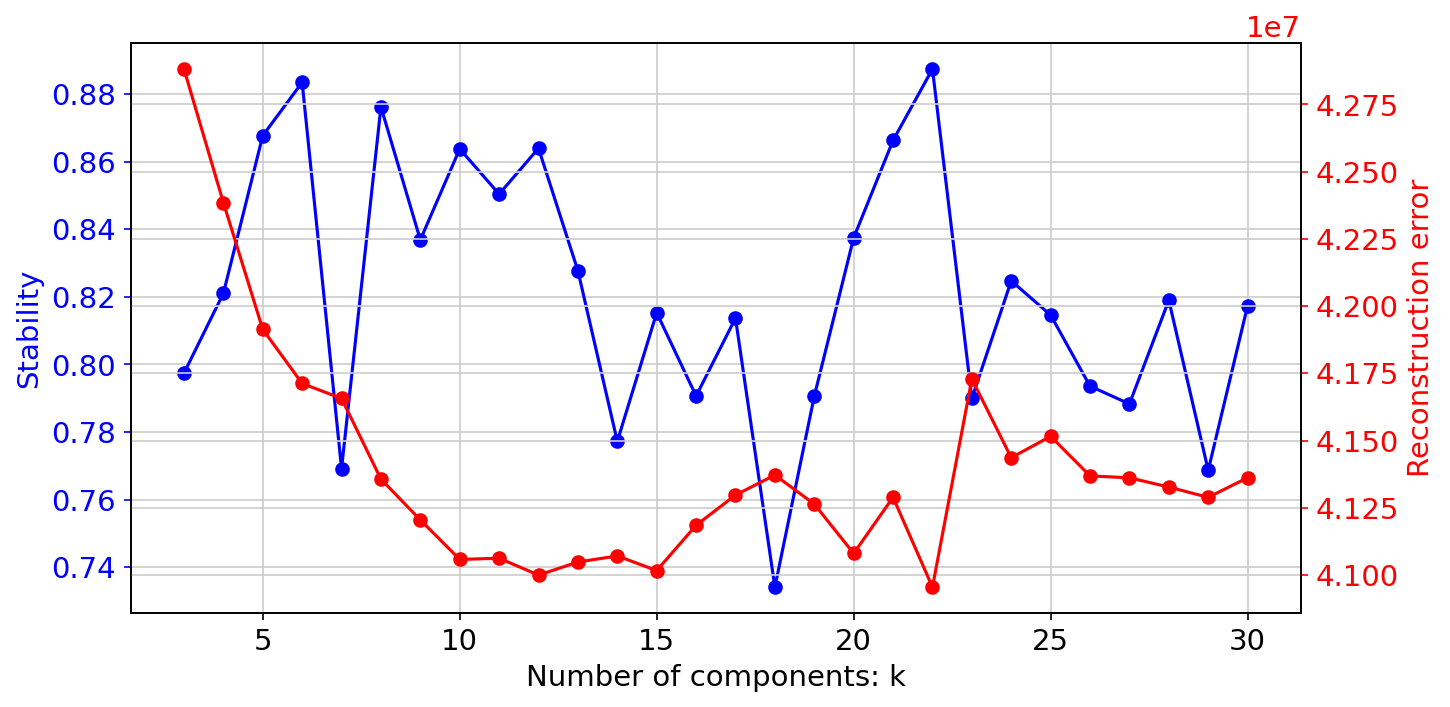

In [22]:
# plot stability and reconstruction error

plt.figure(figsize=(10, 5))
plt.plot(eval_metrics.index, eval_metrics["stability"], "o-", color="b")
plt.grid(True)
plt.ylabel("Stability", color="b")
plt.xlabel("Number of components: k")
plt.gca().tick_params(axis="y", colors="b")
plt.twinx()
plt.plot(eval_metrics.index, eval_metrics["rec_error"], "o-", color="r")
plt.ylabel("Reconstruction error", color="r")
plt.gca().tick_params(axis="y", colors="r")
plt.show()

### Create clustermap plots

In [23]:
best_k = 22

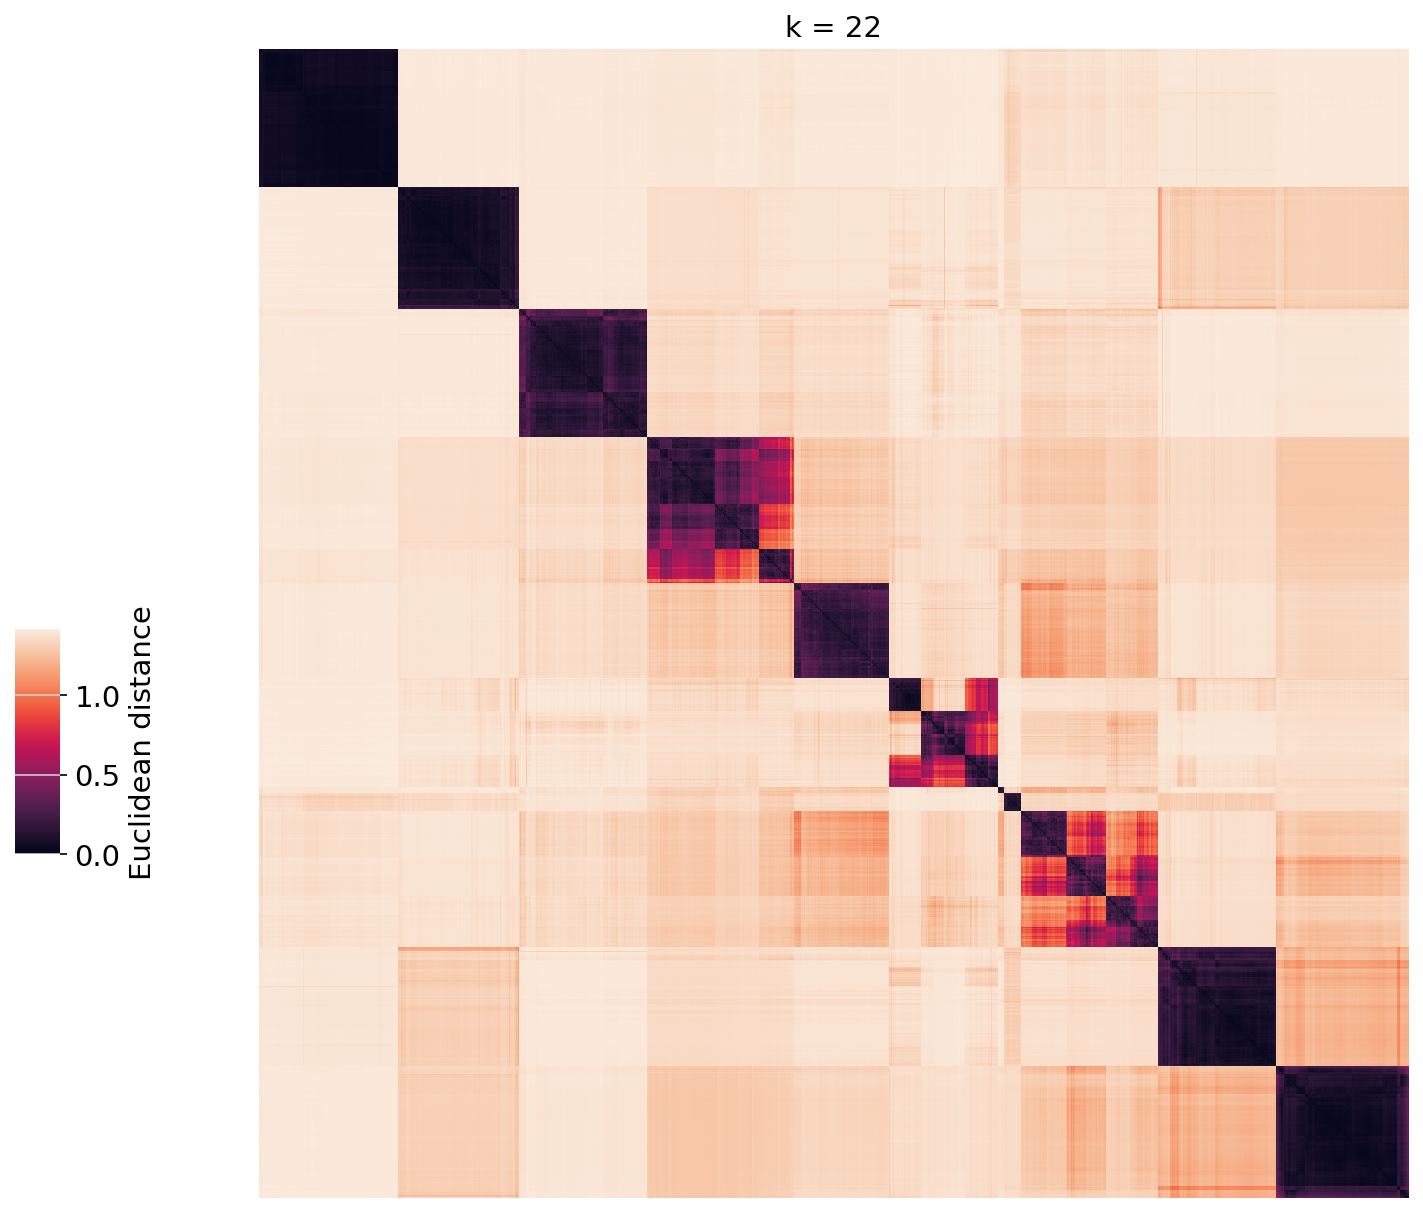

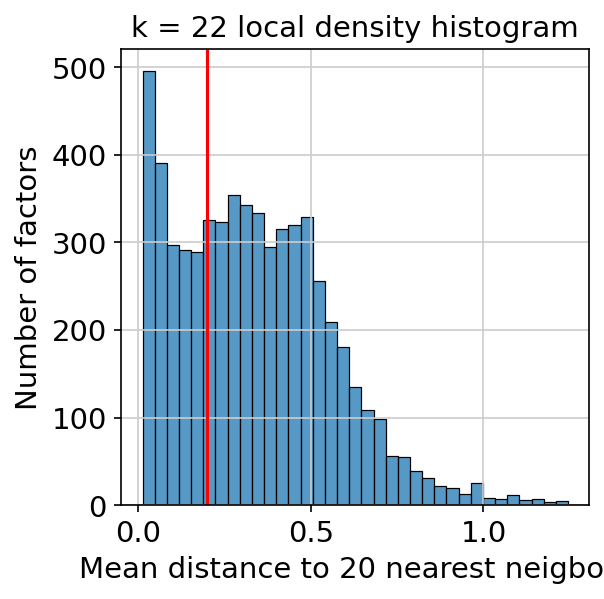

In [24]:
cg = sns.clustermap(
    consensus_stat[best_k]["topk_euc_dist"].cpu().numpy(),
    row_cluster=True,
    col_cluster=True,
    cbar_pos=(0.05, 0.25, 0.03, 0.15),
    xticklabels=False,
    yticklabels=False,
    rasterized=True,
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
# cg.cax.set_visible(False)
cg.cax.set_ylabel("Euclidean distance")
cg.ax_heatmap.set_title(f"k = {best_k}")
plt.show()

sns.histplot(consensus_stat[k]["local_neigh_dist"].cpu().numpy())
ymax = plt.gca().get_ylim()[1]
plt.vlines(density_threshold, ymin=0, ymax=ymax, color="Red")
plt.xlabel(f"Mean distance to {int(num_repeats * local_neighborhood_size)} nearest neigbors")
plt.ylabel("Number of factors")
plt.title(f"k = {best_k} local density histogram")
plt.ylim(0, ymax)

plt.show()

### Compute per-cell loadings

The loadings of each factor, computed for each cell.

In [25]:
obsm_key_added = "X_nmf"

In [ ]:
# get per-cell factor loadings using the best k: this takes time
# set if_get_final_gene_loading as True to get gene loading for full transcriptome
df = get_embedding(dataset, pipeline, k=best_k, if_get_final_gene_loading=True)

 43%|████▎     | 21/49 [00:25<00:34,  1.22s/it]

In [ ]:
# # add this information to the anndata object

adata.obsm["X_nmf"] = df.loc[adata.obs_names].values
adata.obsm["X_nmf"].shape

In [ ]:
# see whether the loadings sum to 1 (nearly)

adata.obsm["X_nmf"].sum(axis=1)

In [ ]:
df = pd.DataFrame(adata.obsm["X_nmf"])

In [ ]:
full_D_kg = getattr(pipeline[-1], f"full_D_{best_k}_kg")
full_D_kg = full_D_kg.cpu().numpy()

full_D_kg = pd.DataFrame(full_D_kg)
full_D_kg.columns = adata.var.index
full_D_kg = full_D_kg.T